# Model selection using information criteria

author: Audrey Olivier

Theory background: model selection refers to the task of selecting a statistical model from a set of candidate models, given some data. A good model is amodel that is able to explain the data well (high model evidence). Given models of same explanatory power, the simplest model should be chosen (Ockam razor). Several simple criteria can be used to compute a model's quality and thus perform model selection. UQpy implements three citeria: 
<br>
Bayesian information criterion (BIC)
$$ BIC = ln(n) k - 2 ln(\hat{L}) $$

Akaike information criterion (AIC)
$$ AIC = 2 k - 2 ln (\hat{L})  $$

Corrected formula for AIC (AICc), for small data sets 
$$ AICc = AIC + \frac{2k(k+1)}{n-k-1} $$

For all formula above, $k$ is the number of parameters characterizing the model, $\hat{L}$ is the maximum value of the likelihood function and $n$ the number of data points. The best model is the one that minimizes the cirterion. All three formulas have a model fit term (find the model that minimizes the negative log likelihood) and a penalty term that increases as the number of model parameters (model complexity) increases.

Reference: *Burnham, K. P.; Anderson, D. R. (2002), Model Selection and Multimodel Inference: A Practical Information-Theoretic Approach (2nd ed.), Springer-Verlag, ISBN 0-387-95364-7*

## Example 1: selection between different univariate distributions

In [1]:
# import the required packages
from UQpy.Inference import InferenceModel, InfoModelSelection
from UQpy.RunModel import RunModel
from UQpy.Distributions import Distribution
import numpy as np
import matplotlib.pyplot as plt

Generate data using a gamma distribution.

In [2]:
from scipy.stats import gamma
data = gamma(a=2, loc=0, scale=1).rvs(size=500).reshape((-1,1))
print(data.shape)

(500, 1)


Define the models to be compared, then call InfoModelSelection to perform model selection. By default, InfoModelSelection returns its outputs, fitted parameters, value of the chosen criteria, model probabilities and so on, in a sorted order, i.e., starting with the most probable model. However, if setting sorted_ouputs=False, the class output attributes are given in the same order as the candidate_models.

In [3]:
# Define the models to be compared, for each model one must create an instance of the model class
distributions = ['exponential', 'gamma', 'chisquare']
nparams_list = [2, 3, 3]
candidate_models = []
for i, distrib in enumerate(distributions):
    M = InferenceModel(name=distrib, distribution_object=Distribution(distrib), nparams=nparams_list[i])
    candidate_models.append(M)

Sorted model using BIC criterion: gamma, chisquare, exponential
Sorted model using AIC criterion: gamma, chisquare, exponential
Sorted model using AICc criterion: gamma, chisquare, exponential


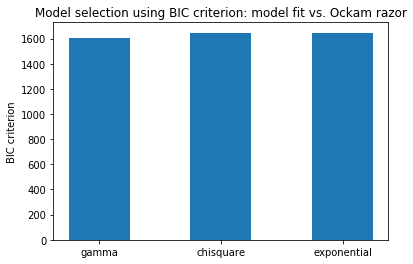

Shape parameter of the gamma distribution: 1.604757380456154
DoF of the chisquare distribution: 2.146241397383128


In [4]:
# Perform model selection using different information criteria
criteria = ['BIC', 'AIC', 'AICc']
for criterion in criteria:
    selector = InfoModelSelection(candidate_models=candidate_models, data=data, criterion=criterion, 
                                  sorted_outputs=True, iter_optim=5)
    print('Sorted model using '+criterion+' criterion: '+', '.join(m.name for m in 
                                                                   selector.candidate_models))
    if criterion == 'BIC':
        criterion_value = selector.criterion_values
        sorted_names = [m.name for m in selector.candidate_models]
        param = [m.mle for m in selector.ml_estimators]
        
width = 0.5
ind = np.arange(len(sorted_names))
p1 = plt.bar(ind, criterion_value, width = width)
#p2 = plt.bar(ind, criterion_value-data_fit_value, bottom=data_fit_value, width = width)

plt.ylabel('BIC criterion')
plt.title('Model selection using BIC criterion: model fit vs. Ockam razor')
plt.xticks(ind, sorted_names)
#plt.legend((p1[0], p2[0]), ('Data fit', 'Ockam razor'))

plt.show()

print('Shape parameter of the gamma distribution: {}'.format(param[sorted_names.index('gamma')][0]))
print('DoF of the chisquare distribution: {}'.format(param[sorted_names.index('chisquare')][0]))

Note that here both the chisquare and gamma are capable of explaining the data, with $a = \nu/2$, $a$ is gamma's shape parameter and $\nu$ is the number of DOFs in chi-square distribution.

## Example 2: model selection in regression -  $y=X \theta + \epsilon$

Use the RunModel module to perform forward propagation. 

In [5]:
# Generate data from a quadratic function
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

h_true = RunModel(model_script='pfn_models.py', model_object_name = 'model_quadratic', var_names = ['theta_0', 'theta_1'])
h_true.run(samples=param_true)
data = h_true.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print('Shape of data: {}'.format(data.shape))

Shape of data: (50,)


In [6]:
# Create instances of the Model class for three models: linear, quadratic and cubic
names = ['linear', 'quadratic', 'cubic']
candidate_models = []
for i in range(3):
    h_func = RunModel(model_script='pfn_models.py', model_object_name='model_'+names[i])
    M = InferenceModel(run_model_object=h_func, nparams=i+1, name=names[i], error_covariance=error_covariance)
    candidate_models.append(M)

Apart from the data, candidate models and method (BIC, AIC...), InfoModelSelection also takes as inputs lists of inputs to the maximum likelihood class (iter_optim, method_optim, ...). Those inputs should be lists of length len(candidate_models).

In [7]:
# Perform model selection using BIC criterion
selector = InfoModelSelection(candidate_models=candidate_models, data=data, criterion='BIC', 
                              method=['nelder-mead']*3, sorted_outputs=True)
selector.run_estimation(iter_optim=1)
print('Sorted models: ', [m.name for m in selector.candidate_models])
print('Values of criterion: ', selector.criterion_values)
print('Values of data fit:', [cr-pe for (cr, pe) in zip(selector.criterion_values, selector.penalty_terms)])
print('Values of penalty term (complexity):', selector.penalty_terms)
print('Values of model probabilities:', selector.probabilities)

Sorted models:  ['quadratic', 'cubic', 'linear']
Values of criterion:  [144.17722397552888, 147.64999001961806, 25514.440371268927]
Values of data fit: [136.3531779646726, 135.91392100333363, 25510.5283482635]
Values of penalty term (complexity): [7.824046010856292, 11.736069016284437, 3.912023005428146]
Values of model probabilities: [0.8502270590745232, 0.14977294092547674, 0.0]


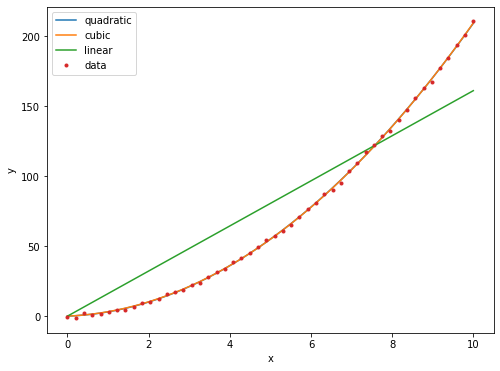

In [8]:
# Plot the results
domain = np.linspace(0, 10, 50)
fig, ax = plt.subplots(figsize=(8,6))

var_names = ['theta_0', 'theta_1']
for i in range(3):
    h_func = RunModel(model_script='pfn_models.py', model_object_name='model_'+selector.candidate_models[i].name)
    h_func.run(samples=selector.ml_estimators[i].mle.reshape((1, -1)))
    y = h_func.qoi_list[0].reshape((-1,))
    ax.plot(domain, y, label = selector.candidate_models[i].name)

plt.plot(domain, data, linestyle='none', marker='.', label='data')
plt.xlabel('x')
plt.ylabel('y')
    
plt.legend()
plt.show()

For this case, one can observe that both the quadratic and cubic model are capable of explaining the data. The cubic model is penalized due to its higher complexity (penalty_term) and thus the quadratic model is preferred.